In [52]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [82]:
def load_mnist(path, kind='train'):
    """Load Fashion-MNIST data from CSV files."""
    if kind == 'train':
        df = pd.read_csv(f'{path}/fashion-mnist_train.csv')
    else:  # 't10k'
        df = pd.read_csv(f'{path}/fashion-mnist_test.csv')

    # Separate labels from image data
    y = df['label'].values
    X = df.drop('label', axis=1).values
    return X, y

# Load the dataset
X_train, y_train = load_mnist('data/fashion_mnist', kind='train')
X_test, y_test = load_mnist('data/fashion_mnist', kind='t10k')

# Normalize pixel values to the range 0-1
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape data for neural network (28x28 -> 784)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")


Training set shape: (60000, 28, 28, 1), Test set shape: (10000, 28, 28, 1)


In [85]:
def filter_classes(X, y, classes=[5, 7]):
    """Filter only the specified classes from the dataset."""
    train_filter = np.isin(y, classes)
    X_filtered = X[train_filter]
    y_filtered = y[train_filter]
    return X_filtered, y_filtered

# Filter for classes 5 (sandal) and 7 (sneaker)
X_train_filtered, y_train_filtered = filter_classes(X_train, y_train)
X_test_filtered, y_test_filtered = filter_classes(X_test, y_test)

# Verify filtered shapes
print(f"Filtered training set shape: {X_train_filtered.shape}, Filtered test set shape: {X_test_filtered.shape}")


Filtered training set shape: (12000, 28, 28, 1), Filtered test set shape: (2000, 28, 28, 1)


In [86]:
from tensorflow.keras.utils import to_categorical

def one_hot_encode_labels(y_train, y_test, class_mapping={5: 0, 7: 1}):
    """Convert class labels to one-hot encoding."""
    # Map original class labels (5 and 7) to new labels (0 and 1)
    y_train_encoded = np.array([class_mapping[label] for label in y_train])
    y_test_encoded = np.array([class_mapping[label] for label in y_test])

    # Apply One-Hot Encoding
    y_train_one_hot = to_categorical(y_train_encoded, num_classes=2)
    y_test_one_hot = to_categorical(y_test_encoded, num_classes=2)

    return y_train_one_hot, y_test_one_hot

# Apply one-hot encoding to the training and testing labels
y_train_one_hot, y_test_one_hot = one_hot_encode_labels(y_train_filtered, y_test_filtered)

# Display a sample of the encoded labels
print(f"Original labels (first 10): {y_train_filtered[:10]}")
print(f"One-Hot Encoded labels (first 10): \n{y_train_one_hot[:10]}")

Original labels (first 10): [5 7 7 5 5 7 5 7 7 5]
One-Hot Encoded labels (first 10): 
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [87]:
# Mostrar las formas de los conjuntos
print(f"Forma del conjunto de entrenamiento: {X_train_filtered.shape}")
print(f"Forma del conjunto de validación: {X_test_filtered.shape}")

# Calcular los pesos de las clases para manejar el desbalance (balanceado)
from sklearn.utils.class_weight import compute_class_weight

# Calcular los pesos de las clases basados en las etiquetas originales (5 para sandalias, 7 para zapatillas)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_filtered), y=y_train_filtered)

# Crear un diccionario con los pesos de clase
class_weights_dict = dict(enumerate(class_weights))

# Mostrar los pesos de clase calculados
print(f"Pesos de clase calculados: {class_weights_dict}")

# Mostrar la distribución de clases en el conjunto de entrenamiento
unique, counts = np.unique(y_train_filtered, return_counts=True)
print(f"Distribución de clases: {dict(zip(unique, counts))}")


Forma del conjunto de entrenamiento: (12000, 28, 28, 1)
Forma del conjunto de validación: (2000, 28, 28, 1)
Pesos de clase calculados: {0: np.float64(1.0), 1: np.float64(1.0)}
Distribución de clases: {np.int64(5): np.int64(6000), np.int64(7): np.int64(6000)}


In [103]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjunto de entrenamiento y validación
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_filtered,   # Imágenes de entrenamiento
    y_train_one_hot,    # Etiquetas de entrenamiento (en formato one-hot)
    test_size=0.2,      # El 20% de los datos se usarán para la validación
    random_state=42     # Fijar una semilla para asegurar que la división sea reproducible
)


In [88]:
# Convertir las etiquetas one-hot a enteras
def one_hot_to_integer(y_one_hot):
    """Convertir etiquetas one-hot a enteros."""
    return np.argmax(y_one_hot, axis=1)

# Convertir etiquetas one-hot a enteras para el conjunto de entrenamiento y validación
y_train_int = one_hot_to_integer(y_train_split)
y_val_int = one_hot_to_integer(y_val_split)

# Crear el modelo con sparse_categorical_crossentropy
def create_model1(input_shape=(28, 28, 1)):
    """Modelo alternativo para clasificación de sandalias y zapatillas."""
    model = models.Sequential([
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),  # Dropout para reducir overfitting
        layers.Dense(2, activation='softmax')  # Dos clases: sandalias y zapatillas
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Cambiar a sparse_categorical_crossentropy
    return model

# Crear el modelo
model_01 = create_model1()
model_01.summary()  # Mostrar la arquitectura del modelo

# Entrenar el modelo con los datos de entrenamiento y validación
history = model_01.fit(
    X_train_split, y_train_int,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_split, y_val_int),
    class_weight=class_weights_dict,  # Usar los pesos de clase para manejar el desbalance
    verbose=2
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 894,466 (3.41 MB)

 Trainable params: 894,466 (3.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
150/150 - 24s - 157ms/step - accuracy: 0.9375 - loss: 0.1623 - val_accuracy: 0.9525 - val_loss: 0.1319
Epoch 2/10
150/150 - 41s - 276ms/step - accuracy: 0.9800 - loss: 0.0611 - val_accuracy: 0.9817 - val_loss: 0.0530
Epoch 3/10
150/150 - 40s - 265ms/step - accuracy: 0.9859 - loss: 0.0436 - val_accuracy: 0.9829 - val_loss: 0.0523
Epoch 4/10
150/150 - 21s - 141ms/step - accuracy: 0.9910 - loss: 0.0273 - val_accuracy: 0.9821 - val_loss: 0.0474
Epoch 5/10
150/150 - 41s - 273ms/step - accuracy: 0.9929 - loss: 0.0191 - val_accuracy: 0.9867 - val_loss: 0.0362
Epoch 6/10
150/150 - 40s - 264ms/step - accuracy: 0.9953 - loss: 0.0138 - val_accuracy: 0.9875 - val_loss: 0.0428
Epoch 7/10
150/150 - 22s - 147ms/step - accuracy: 0.9945 - loss: 0.0144 - val_accuracy: 0.9854 - val_loss: 0.0479
Epoch 8/10
150/150 - 40s - 264ms/step - accuracy: 0.9971 - loss: 0.0101 - val_accuracy: 0.9846 - val_loss: 0.0550
Epoch 9/10
150/150 - 22s - 146ms/step - accuracy: 0.9973 - loss: 0.0077 - val_accuracy: 

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


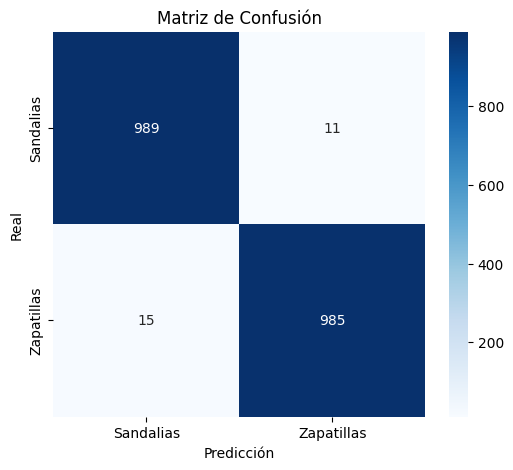

In [113]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hacer predicciones en el conjunto de prueba
y_pred = model_01.predict(X_test_filtered)
y_pred_classes = np.argmax(y_pred, axis=1)  # Obtener las clases predichas

# Calcular la matriz de confusión
cm = confusion_matrix(np.argmax(y_test_one_hot, axis=1), y_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sandalias', 'Zapatillas'], yticklabels=['Sandalias', 'Zapatillas'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


In [89]:
# Model 2
def create_model2(input_shape=(28, 28, 1)):
    """Modelo alternativo para clasificación de sandalias y zapatillas con más capas convolucionales."""
    model = models.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),  # Dropout reducido para prevenir overfitting
        layers.Dense(2, activation='softmax')  # Dos clases: sandalias y zapatillas
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Crear el modelo
model_02 = create_model2()
model_02.summary()  # Mostrar la arquitectura del modelo

# Entrenar el modelo con los datos de entrenamiento y validación
history2 = model_02.fit(
    X_train_split, y_train_int,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_split, y_val_int),
    class_weight=class_weights_dict,  # Usar los pesos de clase para manejar el desbalance
    verbose=2
)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,442 (427.51 KB)

 Trainable params: 109,442 (427.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
150/150 - 10s - 70ms/step - accuracy: 0.9112 - loss: 0.2308 - val_accuracy: 0.9504 - val_loss: 0.1320
Epoch 2/10
150/150 - 9s - 60ms/step - accuracy: 0.9601 - loss: 0.1143 - val_accuracy: 0.9692 - val_loss: 0.0907
Epoch 3/10
150/150 - 10s - 70ms/step - accuracy: 0.9708 - loss: 0.0853 - val_accuracy: 0.9663 - val_loss: 0.0838
Epoch 4/10
150/150 - 10s - 66ms/step - accuracy: 0.9784 - loss: 0.0618 - val_accuracy: 0.9779 - val_loss: 0.0724
Epoch 5/10
150/150 - 9s - 62ms/step - accuracy: 0.9822 - loss: 0.0514 - val_accuracy: 0.9787 - val_loss: 0.0624
Epoch 6/10
150/150 - 10s - 68ms/step - accuracy: 0.9874 - loss: 0.0383 - val_accuracy: 0.9812 - val_loss: 0.0581
Epoch 7/10
150/150 - 11s - 74ms/step - accuracy: 0.9899 - loss: 0.0303 - val_accuracy: 0.9821 - val_loss: 0.0604
Epoch 8/10
150/150 - 9s - 59ms/step - accuracy: 0.9942 - loss: 0.0204 - val_accuracy: 0.9825 - val_loss: 0.0590
Epoch 9/10
150/150 - 10s - 64ms/step - accuracy: 0.9942 - loss: 0.0171 - val_accuracy: 0.9842 - val

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


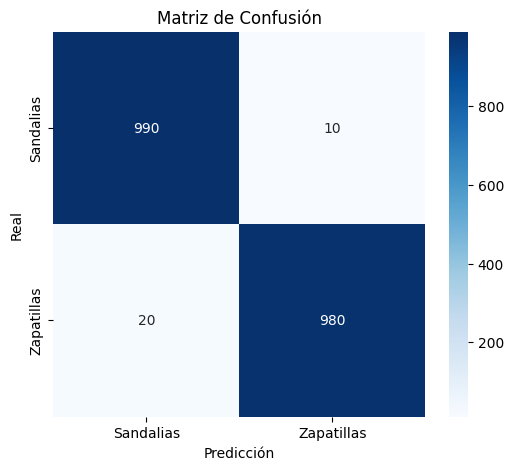

In [104]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hacer predicciones en el conjunto de prueba
y_pred = model_02.predict(X_test_filtered)
y_pred_classes = np.argmax(y_pred, axis=1)  # Obtener las clases predichas

# Calcular la matriz de confusión
cm = confusion_matrix(np.argmax(y_test_one_hot, axis=1), y_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sandalias', 'Zapatillas'], yticklabels=['Sandalias', 'Zapatillas'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


In [90]:
# Crear el modelo alternativo 3
def create_model3(input_shape=(28, 28, 1)):
    """Modelo alternativo 3 para clasificación de sandalias y zapatillas, con BatchNormalization y RMSprop."""
    model = models.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),  # Añadir BatchNormalization
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.BatchNormalization(),  # Añadir BatchNormalization
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        layers.BatchNormalization(),  # Añadir BatchNormalization
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),  # Dropout para prevenir overfitting
        layers.Dense(2, activation='softmax')  # Dos clases: sandalias y zapatillas
    ])

    # Usar RMSprop como optimizador para el modelo
    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Crear el modelo
model_03 = create_model3()
model_03.summary()  # Mostrar la arquitectura del modelo

# Entrenar el modelo con los datos de entrenamiento y validación
history3 = model_03.fit(
    X_train_split, y_train_int,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_split, y_val_int),
    class_weight=class_weights_dict,  # Usar los pesos de clase para manejar el desbalance
    verbose=2
)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,338 (431.01 KB)

 Trainable params: 109,890 (429.26 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
150/150 - 16s - 108ms/step - accuracy: 0.9395 - loss: 0.1627 - val_accuracy: 0.4975 - val_loss: 1.2524
Epoch 2/10
150/150 - 20s - 133ms/step - accuracy: 0.9709 - loss: 0.0825 - val_accuracy: 0.7792 - val_loss: 0.4250
Epoch 3/10
150/150 - 13s - 86ms/step - accuracy: 0.9799 - loss: 0.0544 - val_accuracy: 0.9025 - val_loss: 0.2293
Epoch 4/10
150/150 - 20s - 135ms/step - accuracy: 0.9876 - loss: 0.0375 - val_accuracy: 0.9767 - val_loss: 0.0627
Epoch 5/10
150/150 - 13s - 84ms/step - accuracy: 0.9899 - loss: 0.0282 - val_accuracy: 0.9758 - val_loss: 0.0821
Epoch 6/10
150/150 - 20s - 136ms/step - accuracy: 0.9925 - loss: 0.0221 - val_accuracy: 0.9787 - val_loss: 0.0837
Epoch 7/10
150/150 - 21s - 137ms/step - accuracy: 0.9943 - loss: 0.0167 - val_accuracy: 0.9800 - val_loss: 0.0969
Epoch 8/10
150/150 - 19s - 129ms/step - accuracy: 0.9950 - loss: 0.0184 - val_accuracy: 0.9567 - val_loss: 0.2139
Epoch 9/10
150/150 - 21s - 142ms/step - accuracy: 0.9941 - loss: 0.0156 - val_accuracy: 0.

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


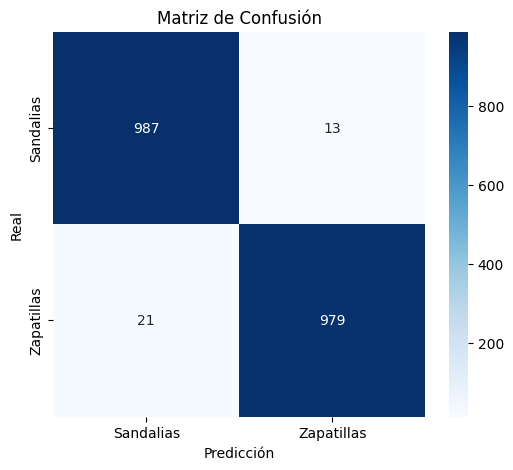

In [106]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hacer predicciones en el conjunto de prueba
y_pred = model_03.predict(X_test_filtered)
y_pred_classes = np.argmax(y_pred, axis=1)  # Obtener las clases predichas

# Calcular la matriz de confusión
cm = confusion_matrix(np.argmax(y_test_one_hot, axis=1), y_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sandalias', 'Zapatillas'], yticklabels=['Sandalias', 'Zapatillas'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


In [109]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Primero corregir el mapeo de etiquetas para el conjunto de test
class_mapping = {5: 0, 7: 1}
y_test_mapped = np.array([class_mapping[label] for label in y_test_filtered])

print("Verificación de etiquetas:")
print(f"Etiquetas originales únicas en test: {np.unique(y_test_filtered)}")
print(f"Etiquetas mapeadas únicas en test: {np.unique(y_test_mapped)}")

# Lista de modelos para comparar
models = {
    'Model_01': model_01,
    'Model_02': model_02,
    'Model_03': model_03
}

# Diccionario para almacenar resultados
results = {}
predictions = {}

# Evaluar cada modelo
for model_name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Evaluando {model_name}")
    print(f"{'='*50}")

    # Hacer predicciones
    y_pred_proba = model.predict(X_test_filtered, verbose=0)
    y_pred_labels = np.argmax(y_pred_proba, axis=1)

    # Guardar predicciones
    predictions[model_name] = y_pred_labels

    # Calcular métricas
    accuracy = accuracy_score(y_test_mapped, y_pred_labels)
    precision = precision_score(y_test_mapped, y_pred_labels, average='weighted')
    recall = recall_score(y_test_mapped, y_pred_labels, average='weighted')
    f1 = f1_score(y_test_mapped, y_pred_labels, average='weighted')

    # Guardar resultados
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Reporte detallado
    print("\nReporte de clasificación:")
    print(classification_report(y_test_mapped, y_pred_labels,
                              target_names=["Sandalia", "Zapatilla"]))

# Crear DataFrame con los resultados para fácil comparación
results_df = pd.DataFrame(results).T
print(f"\n{'='*60}")
print("RESUMEN COMPARATIVO DE MODELOS")
print(f"{'='*60}")
print(results_df.round(4))

# Encontrar el mejor modelo para cada métrica
print(f"\n{'='*40}")
print("MEJORES MODELOS POR MÉTRICA:")
print(f"{'='*40}")
for metric in results_df.columns:
    best_model = results_df[metric].idxmax()
    best_score = results_df.loc[best_model, metric]
    print(f"{metric}: {best_model} ({best_score:.4f})")

# 2. Heatmap de métricas
ax2 = axes[0, 1]
sns.heatmap(results_df.T, annot=True, fmt='.3f', cmap='Blues', ax=ax2)
ax2.set_title('Heatmap de Métricas')

# Análisis de errores
print(f"\n{'='*50}")
print("ANÁLISIS DE ERRORES")
print(f"{'='*50}")

for model_name in models.keys():
    y_pred_labels = predictions[model_name]

    # Encontrar errores
    errors = y_test_mapped != y_pred_labels
    num_errors = np.sum(errors)

    # Tipos de errores
    false_positives = np.sum((y_test_mapped == 0) & (y_pred_labels == 1))
    false_negatives = np.sum((y_test_mapped == 1) & (y_pred_labels == 0))

    print(f"\n{model_name}:")
    print(f"  Total de errores: {num_errors}/{len(y_test_mapped)} ({num_errors/len(y_test_mapped)*100:.2f}%)")
    print(f"  Falsos positivos (Sandalia→Zapatilla): {false_positives}")
    print(f"  Falsos negativos (Zapatilla→Sandalia): {false_negatives}")

# Guardar resultados en CSV (opcional)
results_df.to_csv('model_comparison_results.csv')
print(f"\nResultados guardados en 'model_comparison_results.csv'")

print(f"\n{'='*60}")
print("RECOMENDACIÓN:")
print(f"{'='*60}")
best_overall = results_df.mean(axis=1).idxmax()
print(f"Modelo recomendado: {best_overall}")
print(f"Score promedio: {results_df.loc[best_overall].mean():.4f}")

Verificación de etiquetas:
Etiquetas originales únicas en test: [5 7]
Etiquetas mapeadas únicas en test: [0 1]

Evaluando Model_01
Accuracy: 0.9870
Precision: 0.9870
Recall: 0.9870
F1-Score: 0.9870

Reporte de clasificación:
              precision    recall  f1-score   support

    Sandalia       0.99      0.99      0.99      1000
   Zapatilla       0.99      0.98      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000


Evaluando Model_02
Accuracy: 0.9850
Precision: 0.9850
Recall: 0.9850
F1-Score: 0.9850

Reporte de clasificación:
              precision    recall  f1-score   support

    Sandalia       0.98      0.99      0.99      1000
   Zapatilla       0.99      0.98      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.99      0.98      0.98      2000
weighted avg       0.99      0.98      0.98      2000


Evalua

EVALUACIÓN DEL MODEL_01 EN CONJUNTO DE TESTING
Forma del conjunto de testing: (2000, 28, 28, 1)
Etiquetas originales únicas: [5 7]
Distribución de clases en testing:
  Clase 5 (Sandalia): 1000 muestras
  Clase 7 (Zapatilla): 1000 muestras

Etiquetas después del mapeo: [0 1]
Mapeo aplicado: Sandalia(5)→0, Zapatilla(7)→1

REALIZANDO PREDICCIONES...
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Forma de las probabilidades predichas: (2000, 2)
Predicciones únicas: [0 1]

MÉTRICAS DE RENDIMIENTO
Accuracy:  0.9870 (98.70%)
Precision: 0.9870
Recall:    0.9870
F1-Score:  0.9870

REPORTE DETALLADO POR CLASE
              precision    recall  f1-score   support

    Sandalia       0.99      0.99      0.99      1000
   Zapatilla       0.99      0.98      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000


MATRIZ DE CONFUSIÓN
Matriz de confusión:
[[989  11]
 [ 15 985]]


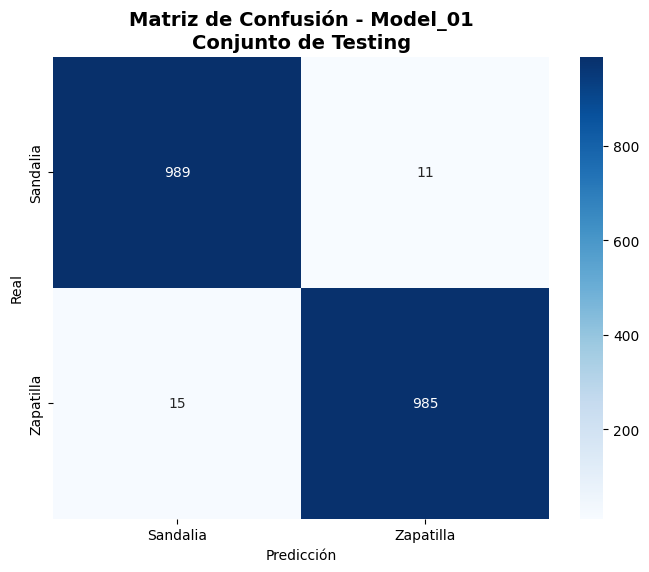


ANÁLISIS DETALLADO DE ERRORES
Total de muestras: 2000
Predicciones correctas: 1974 (98.70%)
Predicciones incorrectas: 26 (1.30%)

Desglose detallado:
  Verdaderos Positivos (Zapatilla→Zapatilla): 985
  Verdaderos Negativos (Sandalia→Sandalia): 989
  Falsos Positivos (Sandalia→Zapatilla): 11
  Falsos Negativos (Zapatilla→Sandalia): 15

RESUMEN FINAL - MODEL_01
Rendimiento general: EXCELENTE
Accuracy: 0.9870 (98.70%)
Total de errores: 26/2000
Confianza promedio: 0.9948
Tendencia: El modelo tiende a clasificar zapatillas como sandalias


In [114]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

print("="*60)
print("EVALUACIÓN DEL MODEL_01 EN CONJUNTO DE TESTING")
print("="*60)

# Verificar los datos de testing
print(f"Forma del conjunto de testing: {X_test_filtered.shape}")
print(f"Etiquetas originales únicas: {np.unique(y_test_filtered)}")
print(f"Distribución de clases en testing:")
unique, counts = np.unique(y_test_filtered, return_counts=True)
for clase, count in zip(unique, counts):
    clase_name = "Sandalia" if clase == 5 else "Zapatilla"
    print(f"  Clase {clase} ({clase_name}): {count} muestras")

# Mapear etiquetas de testing de {5,7} a {0,1}
class_mapping = {5: 0, 7: 1}
y_test_mapped = np.array([class_mapping[label] for label in y_test_filtered])

print(f"\nEtiquetas después del mapeo: {np.unique(y_test_mapped)}")
print(f"Mapeo aplicado: Sandalia(5)→0, Zapatilla(7)→1")

# Hacer predicciones con model_01
print(f"\n{'='*40}")
print("REALIZANDO PREDICCIONES...")
print(f"{'='*40}")

y_pred_proba = model_01.predict(X_test_filtered, verbose=1)
y_pred_labels = np.argmax(y_pred_proba, axis=1)

print(f"Forma de las probabilidades predichas: {y_pred_proba.shape}")
print(f"Predicciones únicas: {np.unique(y_pred_labels)}")

# Calcular métricas de rendimiento
print(f"\n{'='*40}")
print("MÉTRICAS DE RENDIMIENTO")
print(f"{'='*40}")

accuracy = accuracy_score(y_test_mapped, y_pred_labels)
precision = precision_score(y_test_mapped, y_pred_labels, average='weighted')
recall = recall_score(y_test_mapped, y_pred_labels, average='weighted')
f1 = f1_score(y_test_mapped, y_pred_labels, average='weighted')

print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Reporte detallado por clase
print(f"\n{'='*40}")
print("REPORTE DETALLADO POR CLASE")
print(f"{'='*40}")
print(classification_report(y_test_mapped, y_pred_labels,
                          target_names=["Sandalia", "Zapatilla"]))

# Matriz de confusión
print(f"\n{'='*40}")
print("MATRIZ DE CONFUSIÓN")
print(f"{'='*40}")

cm = confusion_matrix(y_test_mapped, y_pred_labels)
print("Matriz de confusión:")
print(cm)

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=["Sandalia", "Zapatilla"],
           yticklabels=["Sandalia", "Zapatilla"])
plt.title('Matriz de Confusión - Model_01\nConjunto de Testing', fontsize=14, fontweight='bold')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Análisis de errores
print(f"\n{'='*40}")
print("ANÁLISIS DETALLADO DE ERRORES")
print(f"{'='*40}")

# Encontrar errores
errors = y_test_mapped != y_pred_labels
num_errors = np.sum(errors)
total_samples = len(y_test_mapped)

# Tipos de errores específicos
true_positives = np.sum((y_test_mapped == 1) & (y_pred_labels == 1))
true_negatives = np.sum((y_test_mapped == 0) & (y_pred_labels == 0))
false_positives = np.sum((y_test_mapped == 0) & (y_pred_labels == 1))
false_negatives = np.sum((y_test_mapped == 1) & (y_pred_labels == 0))

print(f"Total de muestras: {total_samples}")
print(f"Predicciones correctas: {total_samples - num_errors} ({(total_samples - num_errors)/total_samples*100:.2f}%)")
print(f"Predicciones incorrectas: {num_errors} ({num_errors/total_samples*100:.2f}%)")
print(f"\nDesglose detallado:")
print(f"  Verdaderos Positivos (Zapatilla→Zapatilla): {true_positives}")
print(f"  Verdaderos Negativos (Sandalia→Sandalia): {true_negatives}")
print(f"  Falsos Positivos (Sandalia→Zapatilla): {false_positives}")
print(f"  Falsos Negativos (Zapatilla→Sandalia): {false_negatives}")

# Resumen final
print(f"\n{'='*60}")
print("RESUMEN FINAL - MODEL_01")
print(f"{'='*60}")
print(f"Rendimiento general: {'EXCELENTE' if accuracy > 0.95 else 'BUENO' if accuracy > 0.85 else 'REGULAR' if accuracy > 0.75 else 'NECESITA MEJORA'}")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Total de errores: {num_errors}/{total_samples}")
print(f"Confianza promedio: {np.mean(confidence_scores):.4f}")

if false_positives > false_negatives:
    print(f"Tendencia: El modelo tiende a clasificar sandalias como zapatillas")
elif false_negatives > false_positives:
    print(f"Tendencia: El modelo tiende a clasificar zapatillas como sandalias")
else:
    print(f"Tendencia: El modelo tiene errores balanceados entre ambas clases")